In [1]:
import os
import ast
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#### **Load Data**

In [2]:
def load_pickle(filename):
    return pd.read_pickle(filename)

In [3]:
# loading all data
# I'VE DELETE THE 'OLD' FOLDER (if you don't also this will retun an error)
grid = {}
for dirname in os.listdir('grid'):
    if os.path.isdir(f'grid/{dirname}'):
        grid[dirname] = {}
        for filename in os.listdir(f'grid/{dirname}'):
            if filename.endswith('.pkl'):
                key = filename.replace(f'{dirname}_', '').replace('.pkl', '')
                grid[dirname][key] = load_pickle(f'grid/{dirname}/{filename}')

# removing entropy
for key in grid.keys():
    grid[key].pop('entropy_sample', None)


# getting best param (for plotting purposes)
def read_txt(filename):
    with open(filename, 'r') as f:
        for current_line_number, line in enumerate(f, start=1):
            # since struc. does not change the params. we are interested
            # in are always in the same line, i.e. line 3
            if current_line_number == 3:  
                lst = line.split(': ')[-1].strip()
                
                return ast.literal_eval(lst)


for key, value in grid.items():
    # best_param has index
    # best_param_value has the value pertaining to that index
    grid[key]['best_param_value'] = read_txt(f'grid/{key}/{key}.txt')[grid[key]['best_param']]
    
print(grid.keys())
print(grid['fs_sigma_final'].keys())

dict_keys(['fitness_sharing_final', 'fs_sigma_final', 'mirror_prob_final', 'mutation_alg_prob_final', 'mutation_size_final', 'mut_prob_final', 'pop_size_final', 'selec_alg_final', 'tour_size_final', 'xo_alg_prob_final', 'xo_prob_final'])
dict_keys(['best_individuals_sample', 'best_param', 'compiled_history', 'variance_sample', 'best_param_value'])


####  **For n Runs (ABF or MBF - avg. or median)**

In [20]:
def compare_configs(metric, parameter, *configs, title='Fitness History', error_bar_step=20, figsize=(6, 4), skip_gen=0, labels=None):
    
    plt.figure(figsize=figsize)
        
    for i, config in enumerate(configs):
        if metric == 'mean':
            y = np.mean(config, axis=1)
            yerr = np.std(config, ddof=1, axis=1) / np.sqrt(len(configs[0]))  # len(config[0]) = n. trials
            
            if skip_gen > 0:
                y = y[skip_gen:]
                yerr = yerr[skip_gen:]
                    
        elif metric == 'median':
            y = np.median(config, axis=1)
            if skip_gen > 0:
                y = y[skip_gen:]
        else:
            raise ValueError('Invalid metric. Accepted are "mean" and "median".')
        
        x = range(len(y))
        
        # Plot the main line
        line, = plt.plot(x, y, label=f'Config. {i+1}' if labels is None else labels[i])
        color = line.get_color()
        
        # Adding error bars (mean only)
        if (error_bar_step > 0) & (metric != 'median'):        
            # Plot error bars at intervals
            error_x = x[::error_bar_step]
            error_y = y[::error_bar_step]
            error_yerr = yerr[::error_bar_step]
            plt.errorbar(error_x, error_y, yerr=error_yerr, fmt='o', capsize=5, color=color)

    plt.title(title)
    plt.xlabel('Generation')
    plt.ylabel(f'{metric.capitalize()} best {parameter}')
    plt.legend()
    plt.minorticks_on()
    plt.grid(which="minor", linestyle=":", linewidth=0.75)
    plt.show()

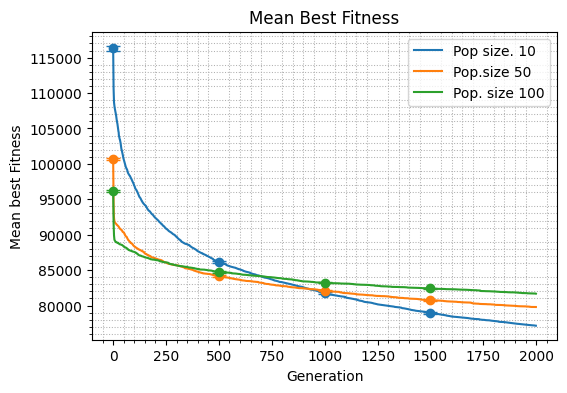

In [21]:
compare_configs('mean', 'Fitness',
                grid['pop_size_final']['best_individuals_sample'][0],
                grid['pop_size_final']['best_individuals_sample'][1],
                grid['pop_size_final']['best_individuals_sample'][2],
                error_bar_step=500, title='Mean Best Fitness',
                labels=['Pop size. 10', 'Pop.size 50', 'Pop. size 100'])

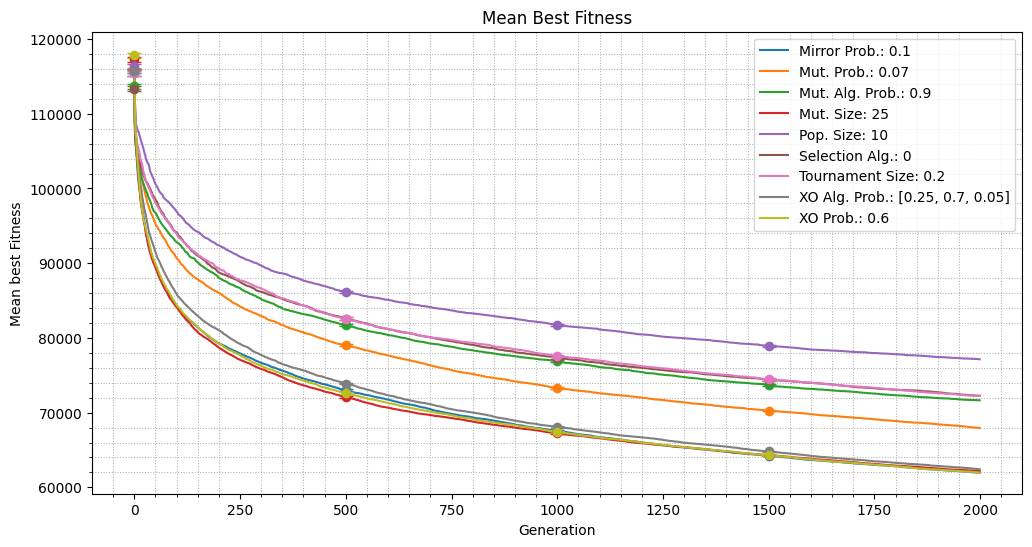

In [22]:
compare_configs('mean', 'Fitness',
                grid['mirror_prob_final']['best_individuals_sample'][grid['mirror_prob_final']['best_param']],
                grid['mut_prob_final']['best_individuals_sample'][grid['mut_prob_final']['best_param']],
                grid['mutation_alg_prob_final']['best_individuals_sample'][grid['mutation_alg_prob_final']['best_param']],
                grid['mutation_size_final']['best_individuals_sample'][grid['mutation_size_final']['best_param']],
                grid['pop_size_final']['best_individuals_sample'][grid['pop_size_final']['best_param']],
                grid['selec_alg_final']['best_individuals_sample'][grid['selec_alg_final']['best_param']],
                grid['tour_size_final']['best_individuals_sample'][grid['tour_size_final']['best_param']],
                grid['xo_alg_prob_final']['best_individuals_sample'][grid['xo_alg_prob_final']['best_param']],
                grid['xo_prob_final']['best_individuals_sample'][grid['xo_prob_final']['best_param']],
                error_bar_step=500, title='Mean Best Fitness', figsize=(12, 6),
                labels=[f'Mirror Prob.: {grid['mirror_prob_final']['best_param_value']}',
                        f'Mut. Prob.: {grid['mut_prob_final']['best_param_value']}',
                        'Mut. Alg. Prob.: 0.9',
                        'Mut. Size: 25',
                        f'Pop. Size: {grid['pop_size_final']['best_param_value']}',
                        f'Selection Alg.: {grid['selec_alg_final']['best_param_value']}',
                        f'Tournament Size: {grid['tour_size_final']['best_param_value']}',
                        f'XO Alg. Prob.: {grid['xo_alg_prob_final']['best_param_value']}',
                        f'XO Prob.: {grid['xo_prob_final']['best_param_value']}'])

#### **Comparison against computation effort**

In [8]:
def get_pop_size(filename, config_idx):
    pop_sizes = read_txt(filename)
    return [pop_size for i, pop_size in enumerate(pop_sizes) if i in config_idx]
    
        
# test
print(f'Pop. size of config. 0: {get_pop_size('grid/pop_size_final/pop_size_final.txt', [0])}')
print(f'Pop. size of configs. 0, 1 and 2, respectively: {get_pop_size('grid/pop_size_final/pop_size_final.txt', [0, 1, 2])}')

Pop. size of config. 0: [10]
Pop. size of configs. 0, 1 and 2, respectively: [10, 50, 100]


In [18]:
def compare_effort(pop_sizes, configs, metric='mean', title='Computational Effort', figsize=(6, 4)):
    plt.figure(figsize=figsize)
    
    for i, config in enumerate(configs):
        x = pop_sizes[i] * np.arange(1, len(config)+1)
        y = np.mean(config, axis=1)
        plt.plot(x, y, label=f'Config. {i+1}: Pop. Size {pop_sizes[i]}')
    
    plt.title(title)
    plt.xlabel('# Fit. Eval.')
    plt.ylabel(f"{'Average' if metric=='mean' else 'Median'} Best Fitness")
    plt.legend()
    plt.minorticks_on()
    plt.grid(which="minor", linestyle=":", linewidth=0.75)
    plt.show()

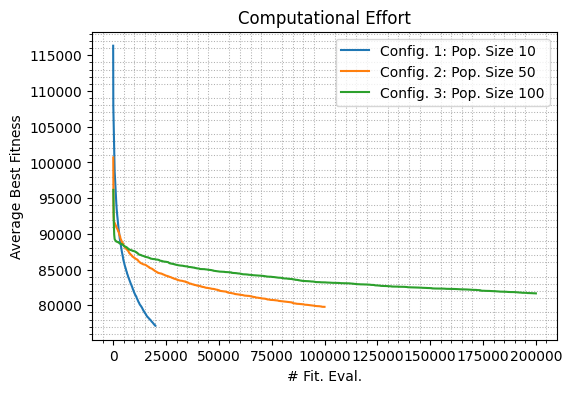

In [19]:
# tests
compare_effort(
    get_pop_size('grid/pop_size_final/pop_size_final.txt', [0, 1, 2]),
    [grid['pop_size_final']['best_individuals_sample'][0], grid['pop_size_final']['best_individuals_sample'][1], grid['pop_size_final']['best_individuals_sample'][2]],
    metric='mean'
)